# Sklearn Workshop 1: Loan Prediction

- Prepare you for project
- We shall go through 3 case studies this week

Announcement:
- Next next week Friday we will meet, and we shall study how to deploy model to FastAPI
- Next next week Saturday no class -> project time
- Next next week Sunday: Presentation 9:00 - 12:00 - Each person 15 mins.

# Let's code!!

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

## 1. Load the data

In [2]:
#get the data from google classroom
df_train = pd.read_csv("data/train_LoanPrediction.csv")
df_test  = pd.read_csv("data/test_LoanPrediction.csv")

In [3]:
#1. get the shape (rows, columns)
df_train.shape  #(614 rows, 13 columns)

#2. try .head()
df_train.head()

#3. try .describe()
df_train.describe()

#4. check whether our data class is balanced, using value_counts(normalize=True)
df_train['Loan_Status'].value_counts() #if you don't put normalize=True, will give you raw number

#our class is imbalanced....
#it means, we have to downsample Y, to equal N

Y    422
N    192
Name: Loan_Status, dtype: int64

### 1.1 Make the dataset valid

- this is not related to cleaning....this is about making the dataset valid....
- please help me downsample Y
- we only need to downsample the training set....because the training set is USED for training
- imbalanced class only affects the model during training


In [4]:
#1. set the cond = Y, and cond = N
condY = df_train.Loan_Status == 'Y'  #to 0 or 1
condN = df_train.Loan_Status == 'N'

#2.. df[condY].sample(n = 192)
#    df[condN].sample
#    we do this many times, do whole ML thing, and do the average....
df_trainY = df_train[condY].sample(n=192, random_state=999)
df_trainN = df_train[condN] #also 192

#3. concat these two dfs
df_train = pd.concat([df_trainY, df_trainN])

df_train.Loan_Status.value_counts()


Y    192
N    192
Name: Loan_Status, dtype: int64

### 2. EDA (Exploratory Data Analysis)
- What is the goal of EDA?
  - To identify promising features (e.g., ApplicantIncome) to predicting the target (e.g., Loan Status)

In [5]:
#0. Check the data type
df_train.dtypes
df_train.drop(columns = ['Loan_ID'], inplace=True)  #this is not a useful feature....
df_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

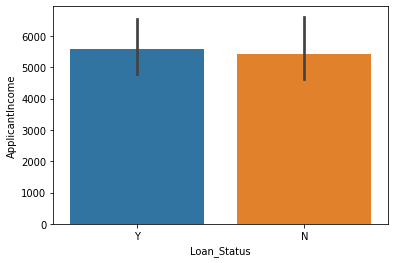

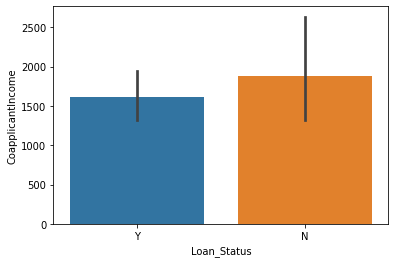

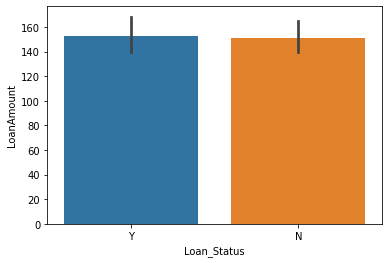

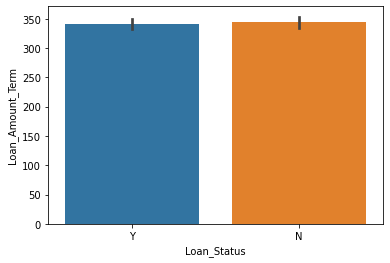

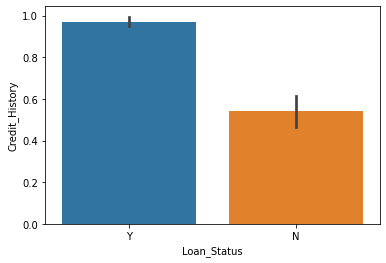

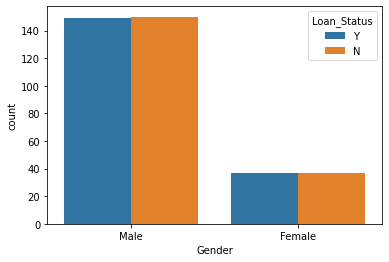

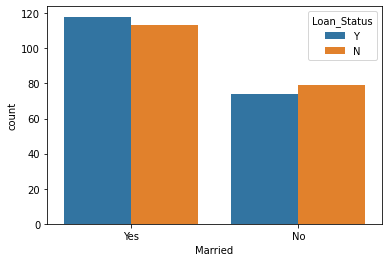

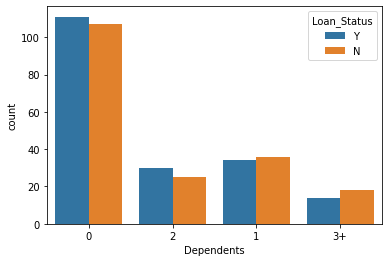

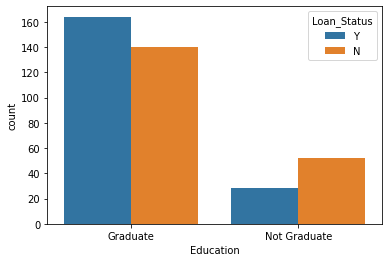

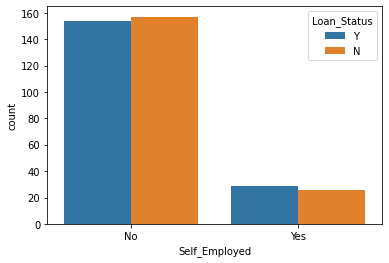

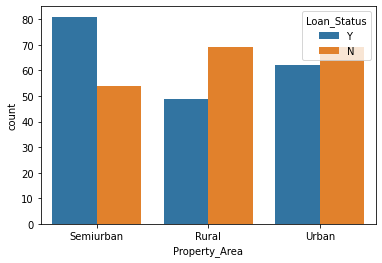

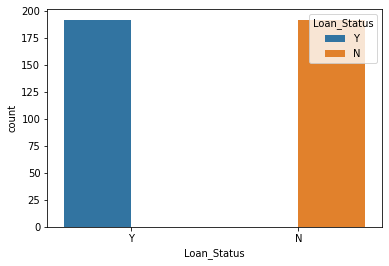

In [6]:
import seaborn as sns

#1. You want to divide into categorical and numerical columns using select_dtypes
df_train.dtypes
num_col = df_train.select_dtypes(include=['int64', 'float64'])
cat_col = df_train.select_dtypes(exclude=['int64', 'float64'])
num_col.columns, cat_col.columns

#2. for numerical type, please do a bar plot with Loan Status
for col in num_col.columns:
    sns.barplot(x = df_train['Loan_Status'], y = df_train[col])
    plt.show()

#3. for categorial type, you may want to use countplot with Loan Status
for col in cat_col.columns:
    sns.countplot(x = df_train[col], hue = df_train['Loan_Status'])
    #similar to hue in scatterplot
    plt.show()
    # sns.countplot()  #because categorical, you need to count, not simply use the magnitude...so cannot use bar...

In [7]:
df_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [8]:
df_train.Loan_Status.unique()

array(['Y', 'N'], dtype=object)

I want to know the mapping of 0 and 1 ['N' 'Y']


<AxesSubplot:>

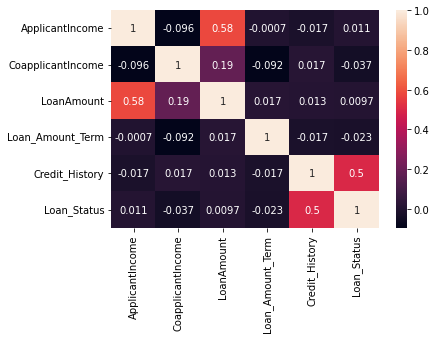

In [9]:
#4. try to do correlation 
#do label encoding the Loan Status
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['Loan_Status'] = le.fit_transform(df_train['Loan_Status'])

#very interesting...our testing set has no loan status, because this is actually a real testing set....

print("I want to know the mapping of 0 and 1", le.inverse_transform([0, 1]))

sns.heatmap(df_train.corr(), annot=True)  #this is only for numeric values....

#Your exercise:  i want you to see which features are useful....
#Credit History, Education, Property Area

#Break until 19:30  

# 3. Feature Extraction

- Remind you guys: we have to split first, then perform cleaning, standardization, etc....
- If not, the information from the testing set may flow to training set, so we want to set aside...

In [10]:
#fortunately, we can skip this step, because
#we already have df_train which is already a training set....

# 4. Cleaning, Standardization, Encoding

- cleaning: filling missing values
- encoding: changing str to int, or change the type of the column, etc.
- standardization: StandardScaler()

In [11]:
#1. please check the missing value in df_train, and of course df_test
df_train.isna().sum()

#just to remind for the filling missing value theory:
# for numeric col, we fill with either mean or median depending on the distribution
# for cat     col, we fill with either majority (mode) or the ratio 
df_train.dtypes

#asking, is there 1.5 dependent in this world?

df_train['Credit_History'].value_counts()  #because there's only 5 groups, it's easy to treat as categorical
                                 #it does not make sense to have something like 1.5 dependents

1.0    269
0.0     87
Name: Credit_History, dtype: int64

In [12]:
df_train.isna().sum()
#Gender:            majority or ratio
#Dependents:        majority or ratio
#Self_Employed:     majority or ratio
#LoanAmount:        median or mean  <---do this
#Loan_Amount_Term:  majority or ratio
#Credit_History:    majority or ratio <---do this

Gender               11
Married               0
Dependents            9
Education             0
Self_Employed        18
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           14
Loan_Amount_Term     10
Credit_History       28
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
ratio = df_train['Credit_History'].value_counts(normalize=True)
print(ratio)

1.0    0.755618
0.0    0.244382
Name: Credit_History, dtype: float64


In [14]:
# #either replace with the majority or keep the ratio
# #majority is good when the majority takes over like 90% of the population
# #otherwise, ratio is better

# #in this case, it's better to fill the missing value with ratio
# #ratio means that we want to keep the ratio 75 25 AFTER filling....
print("Credit history of 1: ", ratio[1])
print("Credit history of 0: ", ratio[0])
print(ratio.index)


Credit history of 1:  0.7556179775280899
Credit history of 0:  0.2443820224719101
Float64Index([1.0, 0.0], dtype='float64')


In [15]:
# #we gonna fill the missing value such that the ratio is kept unchanged
# #format: fillna(pd.Series(random.choice(1, 0), p=probability of the ratios), inplace=True)
missing = df_train.Credit_History.isna().sum()

num1 = int(np.round(ratio[1] * missing))
num0 = int(np.round(ratio[0] * missing))

print(num1, num0)


21 7


In [16]:
df_train['Credit_History'].fillna(1.0, limit = num1, inplace=True)
df_train['Credit_History'].fillna(0.0, limit = num0, inplace=True)

#pd.series is ok, but i feel like limit is much easier

In [17]:
#fill the missing for the test set for credit history

#number of missing values
missing = df_test['Credit_History'].isna().sum()

#get the row index where the missing values located at
cond = df_test['Credit_History'].isna()  #list of true and false
missing_index = df_test[cond].index

#get ratio
ratio = df_test['Credit_History'].value_counts(normalize=True)
print("Test ratio: ", ratio)

series = pd.Series(np.random.choice((1, 0), p=[ratio[1], ratio[0]], size=missing), index=missing_index)
print(series.value_counts(normalize=True))

print("Before: ", df_test['Credit_History'].isna().sum())
print("Before: ", df_test['Credit_History'].value_counts(normalize=True))

df_test['Credit_History'].fillna(series, inplace=True)
df_test['Credit_History'].isna().sum()

print("After: ", df_test['Credit_History'].isna().sum())
print("After: ", df_test['Credit_History'].value_counts(normalize=True))

Test ratio:  1.0    0.825444
0.0    0.174556
Name: Credit_History, dtype: float64
1    0.827586
0    0.172414
dtype: float64
Before:  29
Before:  1.0    0.825444
0.0    0.174556
Name: Credit_History, dtype: float64
After:  0
After:  1.0    0.825613
0.0    0.174387
Name: Credit_History, dtype: float64


In [18]:
#Break: 20:30


/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gender               11
Married               0
Dependents            9
Education             0
Self_Employed        18
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     10
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

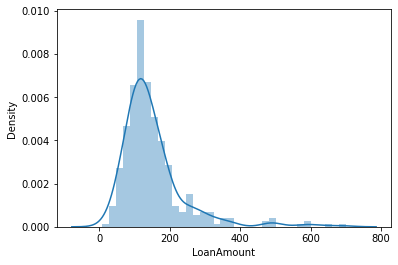

In [19]:
sns.distplot(df_train.LoanAmount)
df_train.LoanAmount.median(), df_train.LoanAmount.mean()

#can you guys help me fill in the LoanAmount with median()
df_train['LoanAmount'].fillna(df_train['LoanAmount'].median(), inplace=True)

df_train.isna().sum()


In [20]:
df_train.dtypes
#recall we want to use education, credit history, property area

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status            int64
dtype: object

In [21]:
df_train.Education.unique()      #have to encode it to 0 and 1  #Ex1
df_train.Property_Area.unique()  #have to one-hot encode into three columns #Ex2

#why one-hot encode Property Area, not encode it into 0, 1, 2
#if we have more than two categories, if we encode into 0, 1, 2
#we create a unintentional order, i.e., the model "may" think that 

#what if we have like 5000 categories....
    #one hot encode this will result in 5000 columns --> this introduces burden to the machine learning model
    #1. NLP --> we basically do like this....
    #2. General case -->
        #1st:  Group these categories into bigger categories, and then one-hot encode
        #2nd:  (not so good) - do label encoding anyway......but note the possible order effect
        
#one hot encoding
#[1, 0, 0], [0, 1, 0], [0, 0, 1]
#one thing you need to know is that you can always cut down one column
#[1, 0], [0, 1], [0, 0]  ==> this is possible, and will save you one more column...
#also this is recommended, because it will not introduce unwanted correlation.....


array(['Semiurban', 'Rural', 'Urban'], dtype=object)

In [22]:
#hint Ex1: LabelEncoder(), map
df_train['Education'] = le.fit_transform(df_train['Education'])
df_test['Education']  = le.transform(df_test['Education'])
le.inverse_transform([0, 1])

#optionally you can use pd.map
#df_train.map({'Graduate': 0, 'Not Graduate': 1})

array(['Graduate', 'Not Graduate'], dtype=object)

In [23]:
df_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [24]:
df_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
294,Male,Yes,0,0,No,2383,3334.0,172.0,360.0,1.0,Semiurban,1
501,Female,No,0,0,No,3159,0.0,100.0,360.0,1.0,Semiurban,1
323,Female,No,0,0,No,3166,2985.0,132.0,360.0,1.0,Rural,1
467,NaN,Yes,0,0,No,16692,0.0,110.0,360.0,1.0,Semiurban,1
476,Male,Yes,2,0,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


In [25]:
#hint Ex2: sklearn.preprocessing OneHotEncoder or pd.get_dummies
df_train = pd.get_dummies(df_train, columns=['Property_Area'], drop_first=True)
df_test  = pd.get_dummies(df_test, columns=['Property_Area'], drop_first=True)

#another possible code
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(sparse=False)  #if sparse =True, it will shrink it

#this index = index, is needed, because we downsample the dataset, so all the index got swapped....

# df_train_ohe_property_area = pd.DataFrame(ohe.fit_transform(df_train[['Property_Area']]), index=df_train.index)

# #check how it looks like
# print(ohe.inverse_transform([ [1, 0, 0], [0, 1, 0], [0, 0, 1]]))

# df_train_ohe_property_area.columns = ['Rural', 'Semiurban', 'Urban']

# df_train = df_train.join(df_train_ohe_property_area)


In [26]:
df_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Semiurban,Property_Area_Urban
294,Male,Yes,0,0,No,2383,3334.0,172.0,360.0,1.0,1,1,0
501,Female,No,0,0,No,3159,0.0,100.0,360.0,1.0,1,1,0
323,Female,No,0,0,No,3166,2985.0,132.0,360.0,1.0,1,0,0
467,NaN,Yes,0,0,No,16692,0.0,110.0,360.0,1.0,1,1,0
476,Male,Yes,2,0,No,6700,1750.0,230.0,300.0,1.0,1,1,0


In [27]:
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Semiurban,Property_Area_Urban
0,LP001015,Male,Yes,0,0,No,5720,0,110.0,360.0,1.0,0,1
1,LP001022,Male,Yes,1,0,No,3076,1500,126.0,360.0,1.0,0,1
2,LP001031,Male,Yes,2,0,No,5000,1800,208.0,360.0,1.0,0,1
3,LP001035,Male,Yes,2,0,No,2340,2546,100.0,360.0,1.0,0,1
4,LP001051,Male,No,0,1,No,3276,0,78.0,360.0,1.0,0,1


In [28]:
df_train.isna().sum()

Gender                     11
Married                     0
Dependents                  9
Education                   0
Self_Employed              18
ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                  0
Loan_Amount_Term           10
Credit_History              0
Loan_Status                 0
Property_Area_Semiurban     0
Property_Area_Urban         0
dtype: int64

In [29]:
df_test.isna().sum()

Loan_ID                     0
Gender                     11
Married                     0
Dependents                 10
Education                   0
Self_Employed              23
ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                  5
Loan_Amount_Term            6
Credit_History              0
Property_Area_Semiurban     0
Property_Area_Urban         0
dtype: int64

In [ ]:
#StandardScaler is usually used for continuous values
#here, Education, Credit_History, and Property Area are all categorical
#standardizing them will lose the category, so we will not do!!!

#break: 14:33 - 14:45

#remind you the steps of data science

#1. load the data (ETL)
#2. exploratory data analysis (EDA)
#3. feature extraction (split the data, decide the features)
#4. preprocessing (cleaning, encoding, standardizing)
#5. modeling

# 5. Modeling

In [32]:
#1. set the X and y
X_train = df_train[ ['Education', 'Credit_History', 'Property_Area_Semiurban', 'Property_Area_Urban'] ]
y_train = df_train['Loan_Status']

X_test = df_test[ ['Education', 'Credit_History', 'Property_Area_Semiurban', 'Property_Area_Urban'] ]
#no y_test, because this dataset does not have the answer....

#2. make sure the shape of X is (samples, features), and y is (samples, )
assert X_train.ndim == 2
assert X_test.ndim  == 2
assert y_train.ndim == 1

print("(samples, features): ", X_train.shape)
print("(samples,         ): ", y_train.shape)
print("(samples, features): ", X_test.shape)


(samples, features):  (384, 4)
(samples,         ):  (384,)
(samples, features):  (367, 4)


In [ ]:
#Regression
#   y is continuous

#Classification
#   y is discrete

In [ ]:
#For regression:
#Baselines:
from sklearn.linear_model import LinearRegression

#Next Level
from sklearn.linear_model import LinearRegression
#but transform your features using
from sklearn.preprocessing import PolynomialFeatures

#Advanced
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm      import SVR


In [56]:
#3. perform cross validation with a selected set of models, to scope down which model is among the best

#3.1 specify the list of algorithms - don't worry - you will learn them in machine learning class
#this is for classification
##Baselines
from sklearn.linear_model import LogisticRegression  #drawing a line based on linear regression but used for classification
from sklearn.naive_bayes import GaussianNB  #drawing a line based on probability

##Situational (but we don't use much)
from sklearn.neighbors import KNeighborsClassifier

##Complex
from sklearn.ensemble import RandomForestClassifier  #using trees to classify
from sklearn.svm import SVC  #drawing a line based on maximum distance
from sklearn.ensemble import GradientBoostingClassifier  #<<-------is the MOST complex
    #XGBoost but is not in sklearn, import XGBoost #<---most powerful algorithm for tabular data (not images, signal)

#any random_state you can use......up to you 

lr = LogisticRegression(random_state=999)
rf = RandomForestClassifier(random_state=999)
sv = SVC(random_state=999)

models = [lr, rf, sv]

#3.2 perform cross validation using KFold
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits = 5, shuffle = True, random_state=999)

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')  #f1, recall, precision, accuracy
    print("Scores: ", score, "- Scores mean: ", score.mean(), "- Scores std (lower better): ", score.std())  #out of 1 ; 1 means perfect accuracy
    #lr, rf, sv

#when they are very close, 
    #how we choose?  we choose the simplest model...
    #what does simplest mean?  LogisticRegression is simplest, and SVM is the most complex....

Scores:  [0.77777778 0.70833333 0.78723404 0.75294118 0.77272727] - Scores mean:  0.7598027205724327 - Scores std (lower better):  0.028067072400877826
Scores:  [0.77777778 0.70833333 0.78723404 0.75862069 0.73333333] - Scores mean:  0.7530598353305618 - Scores std (lower better):  0.028980583434062866
Scores:  [0.77777778 0.70833333 0.78723404 0.75294118 0.73913043] - Scores mean:  0.7530833529834998 - Scores std (lower better):  0.028189901075305543


In [48]:
#4. grid search to find the best version of that model
#remind you: grid search is BASICALLY same as cross validation but for the same model

from sklearn.model_selection import GridSearchCV

model = LogisticRegression(random_state=999)  #<----this is the model I choose, after cross validation

param_grid = dict()
param_grid['solver'] = ['newton-cg', 'lbfgs', 'liblinear']  #this is listed in the sklearn website
#add more parameters here
#param_grid[parameter] = list of parameters to search

#refit means it will pick the best model, and fit again, so it means grid is already the best model after this line
grid = GridSearchCV(model, param_grid, scoring="accuracy", cv=kfold, refit=True)
#scoring = f1, recall, precision, accuracy

#fit the grid, which will basically do cross validation across all combinatiosn, here we only have 3 comb
grid.fit(X_train, y_train)  #remember to use only training set here....

#print the best parameters and accuracy
print(grid.best_params_)
print(grid.best_score_)


{'solver': 'liblinear'}
0.7239917976760082


In [52]:
#confusion matrix 
'''
T = True, F = False
P = Positive, N = Negative
'''

''' 
                        Actual
                    P               N
             P     TP              FP
predict   
             N     FN              TN
'''

#0 here is negative
#1 here is positive

y     = [0, 1, 1, 1, 1, 1]
ypred = [1, 0, 1, 1, 0, 1]

#accuracy = (TP + TN) / (TP + FP + FN + TN)
#accuracy = 3 + 2  /  6 = 5 / 6 = 83%

#but accuracy is NOT good if your data is imbalanced

#recall, precision, f1-score
#recall = TP  / (TP + FN)
#recall = 3   / (3  + 0) = 100%  Recall is used when you don't like FN, e.g., critical - cancer, zombie, terrorists

#precision = TP / (TP + FP)
#precision = 3 /  (3 + 1) = 75% Precision is used when you don't like FP, e.g., search engine

#f1-score = 2 * ( (recall * precision) / (precision + recall) )
        #when precision and recall are both important.....
        #   2 * ( (1      * 0.75)     /   (0.75     +    1  ) )
        
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#if you want all in one table
from sklearn.metrics import classification_report

#if you want the confusion matrix
from sklearn.metrics import confusion_matrix

#format (ytrue, ypred)
print(accuracy_score(y, ypred))
print(precision_score(y, ypred))
print(recall_score(y, ypred))
print(f1_score(y, ypred))

print(classification_report(y, ypred))
print(confusion_matrix(y, ypred))

#for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


0.8333333333333334
0.75
1.0
0.8571428571428571
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6

[[2 1]
 [0 3]]


# 6. Testing / Inference

In [50]:
pred_y = grid.predict(X_test)

pred_y

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,

# 7. Feature Importance

# 8. Saving model